# Unraveling scalar mults and countermeasures

In [1]:
import pickle
import itertools
import glob
import random
import math

from collections import Counter

import numpy as np
import pandas as pd
from scipy.stats import binom, entropy
from scipy.spatial import distance
from tqdm.auto import tqdm, trange
from anytree import PreOrderIter, Walker
from matplotlib import pyplot as plt

from pyecsca.ec.mult import *
from pyecsca.misc.utils import TaskExecutor, silent
from pyecsca.sca.re.tree import Map, Tree

from common import *

## Prepare
Select *divisor name* to restrict the features. Select *kind* to pick the probmap source.

In [2]:
divisor_name = "all"
kind = "all"
allfeats = list(filter(lambda feat: feat not in (1,2,3,4,5), divisor_map[divisor_name]))

In [3]:
# Load
try:
    with open(f"{divisor_name}_{kind}_distrs.pickle", "rb") as f:
        distributions_mults = pickle.load(f)
except FileNotFoundError:
    with open(f"all_{kind}_distrs.pickle", "rb") as f:
        distributions_mults = pickle.load(f)
    for probmap in distributions_mults.values():
        probmap.narrow(allfeats)

In [4]:
allmults = list(distributions_mults.keys())
nmults = len(allmults)
nallfeats = len(allfeats)

## Build dmap and tree

Select the n for building the tree.

In [5]:
nbuild = 10000
alpha = 0.05

In [6]:
# Now go over all divisors, cluster based on overlapping CI for given n?
io_map = {mult:{} for mult in allmults}
for divisor in allfeats:
    prev_ci_low = None
    prev_ci_high = None
    groups = {}
    pvals = {}
    group = 0
    for mult, probmap in sorted(distributions_mults.items(), key=lambda item: -item[1][divisor]):
        # We are going from high to low p.
        pval = probmap[divisor]
        pvals[mult] = pval
        ci_low, ci_high = conf_interval(pval, nbuild, alpha)
        ci_low = max(ci_low, 0.0)
        ci_high = min(ci_high, 1.0)
        if (prev_ci_low is None and prev_ci_high is None) or prev_ci_low >= ci_high:
            g = groups.setdefault(f"arbitrary{group}", set())
            g.add(mult)
            group += 1
        else:
            g = groups.setdefault(f"arbitrary{group}", set())
            g.add(mult)
        prev_ci_low = ci_low
        prev_ci_high = ci_high
    
    #print(f"Divisor: {divisor}, num groups: {group}", end="\n\t")
    #for g in groups.values():
    #    print(len(g), end=", ")
    #print()
    for group, mults in groups.items():
        mult_pvals = [pvals[mult] for mult in mults]
        group_pval_avg = np.mean(mult_pvals)
        group_pval_var = np.var(mult_pvals)
        group_pval_min = np.min(mult_pvals)
        group_pval_max = np.max(mult_pvals)
        for mult in mults:
            io_map[mult][divisor] = (group,  group_pval_avg, group_pval_var, group_pval_min, group_pval_max)

# then build dmap
dmap = Map.from_io_maps(set(distributions_mults.keys()), io_map)

In [7]:
print(dmap.describe())

Total configs: 378, (6_048 bytes)
Rows: 378, (9_722_292 bytes)
Inputs: 3215
Codomain: 11998
None in codomain: False


In [8]:
# deduplicate dmap
dmap.deduplicate()

In [9]:
print(dmap.describe())

Total configs: 378, (14_344 bytes)
Rows: 347, (8_924_972 bytes)
Inputs: 3215
Codomain: 11998
None in codomain: False


In [10]:
# build a tree
with silent():
    tree = Tree.build(set(allmults), dmap)

In [11]:
print(tree.describe())

Dmaps: 1
Total cfgs: 378
Height: 7
Size: 533
Leaves: 347
Precise: False
Leaf sizes: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [12]:
print(tree.render_basic())

378
├── 1
├── 10
│   ├── 1
│   ├── 1
│   ├── 1
│   ├── 1
│   ├── 4
│   │   ├── 1
│   │   └── 3
│   │       ├── 1
│   │       └── 2
│   │           ├── 1
│   │           └── 1
│   ├── 1
│   └── 1
├── 10
│   ├── 1
│   ├── 2
│   │   ├── 1
│   │   └── 1
│   ├── 4
│   │   ├── 1
│   │   └── 3
│   │       ├── 1
│   │       └── 2
│   │           ├── 1
│   │           └── 1
│   └── 3
│       ├── 1
│       ├── 1
│       └── 1
├── 49
│   ├── 1
│   ├── 13
│   │   ├── 1
│   │   ├── 2
│   │   │   ├── 1
│   │   │   └── 1
│   │   ├── 2
│   │   │   ├── 1
│   │   │   └── 1
│   │   ├── 1
│   │   ├── 3
│   │   │   ├── 1
│   │   │   ├── 1
│   │   │   └── 1
│   │   ├── 2
│   │   │   ├── 1
│   │   │   └── 1
│   │   └── 2
│   │       ├── 1
│   │       └── 1
│   ├── 10
│   │   ├── 1
│   │   ├── 4
│   │   │   ├── 1
│   │   │   ├── 2
│   │   │   │   ├── 1
│   │   │   │   └── 1
│   │   │   └── 1
│   │   ├── 1
│   │   └── 4
│   │       ├── 1
│   │       ├── 2
│   │       │   ├── 1
│   │       │   └── 1
│   │      

## Simulate distinguishing using a tree
We can now simulate distinguishing using the tree and how it behaves with increasing the number of samples per divisor collected.

In [ ]:
simulations = 1000

for nattack in trange(100, 10000, 100):
    successes = 0
    pathiness = 0
    for i in range(simulations):
        true_mult = random.choice(allmults)
        probmap = distributions_mults[true_mult]
        node = tree.root
        while True:
            if node.is_leaf:
                break
            divisor = node.dmap_input
            prob = probmap[divisor]
            sampled_prob = binom(nattack, prob).rvs() / nattack
            best_child = None
            true_child = None
            best_group_distance = None
            #print(f"Divisor: {divisor}, prob: {prob}, sampled: {sampled_prob}")
            for child in node.children:
                if true_mult in child.cfgs:
                    true_child = child
                group, group_pval_avg, group_pval_var, group_pval_min, group_pval_max = child.response
                group_distance = min(abs(sampled_prob - group_pval_min), abs(sampled_prob - group_pval_max))
                #print(f"Child {group}, {group_pval_avg}")
                if best_child is None or \
                    (group_distance < best_group_distance):
                    best_child = child
                    best_group_distance = group_distance
                if sampled_prob > group_pval_min and sampled_prob < group_pval_max:
                    best_child = child
                    break
            #print(f"Best {best_child.response}")
            if true_child is not None and true_child != best_child:
                pass
                #print(f"Mistake! {prob}, {sampled_prob} true:{true_child.response}, chosen:{best_child.response}")
            node = best_child
            if true_mult in node.cfgs:
                pathiness += 1
        #print(f"Arrived: {true_mult in node.cfgs}")
        if true_mult in node.cfgs:
            successes += 1
    print(f"{nattack}: success rate {successes/simulations}, pathiness {pathiness/simulations}")

## Simulate distinguishing using a distance metric

We need to first select some features (divisors) from the set of all divisors that we will query
the target with. This set should be the smallest (to not do a lot of queries) yet allow us to distinguish as
much as possible.

### Feature selection using trees + classification error

We can reuse the clustering + tree building approach above and just take the inputs that the greedy tree building choses as the features. However, we can also use more conventional feature selection approaches.

In [86]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import validate_data, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from scipy.special import logsumexp
from sklearn.metrics import euclidean_distances, top_k_accuracy_score, make_scorer, accuracy_score


class EuclidClassifier(ClassifierMixin, BaseEstimator):
    def __init__(self, *, nattack=100):
        self.nattack = nattack

    def fit(self, X, y):
        X, y = validate_data(self, X, y)
        if not np.logical_and(X >= 0, X <= 1).all():
            raise TypeError("Expects valid probabilities in X.")
        self.classes_ = unique_labels(y)
        if len(self.classes_) != len(y):
            raise ValueError("Expects only one sample per class containing the binomial probabilities.")
        self.X_ = X
        self.y_ = y
        return self

    def decision_function(self, X):
        check_is_fitted(self)
        X = validate_data(self, X, reset=False)
        distances = euclidean_distances(X / self.nattack, self.X_)
        return -distances

    def predict(self, X):
        check_is_fitted(self)
        X = validate_data(self, X, reset=False)
        distances = euclidean_distances(X / self.nattack, self.X_)
        closest = np.argmin(distances, axis=1)
        return self.classes_[closest]


class BayesClassifier(ClassifierMixin, BaseEstimator):
    def __init__(self, *, nattack=100):
        self.nattack = nattack

    def fit(self, X, y):
        # X has (nmults = nsamples, nfeats)
        X, y = validate_data(self, X, y)
        if not np.logical_and(X >= 0, X <= 1).all():
            raise TypeError("Expects valid probabilities in X.")
        self.classes_ = unique_labels(y)
        if len(self.classes_) != len(y):
            raise ValueError("Expects only one sample per class containing the binomial probabilities.")
        self.X_ = X
        self.y_ = y
        return self

    def decision_function(self, X):
        check_is_fitted(self)
        X = validate_data(self, X, reset=False)
        # We have a uniform prior, so we can ignore it.
        probas = np.zeros((len(X), len(self.classes_)))
        for i, row in enumerate(X):
            p = binom(self.nattack, self.X_).logpmf(row)
            s = np.sum(p, axis=1)
            log_prob_x = logsumexp(s)
            res = np.exp(s - log_prob_x)
            probas[i, ] = res
        return probas

    def predict_proba(self, X):
        return self.decision_function(X)

    def predict(self, X):
        check_is_fitted(self)
        X = validate_data(self, X, reset=False)
        # We have a uniform prior, so we can ignore it.
        results = np.empty(len(X), dtype=self.classes_.dtype)
        for i, row in enumerate(X):
            p = binom(self.nattack, self.X_).logpmf(row)
            s = np.sum(p, axis=1)
            most_likely = np.argmax(s)
            results[i] = self.classes_[most_likely]
        return results


def to_sklearn(mults_map: dict[MultIdent, ProbMap], feats: list[int]):
    nfeats = len(feats)
    nmults = len(mults_map)
    classes = np.arange(nmults, dtype=np.uint32)
    probs = np.zeros((nmults, nfeats), dtype=np.float64)
    for i, divisor in enumerate(feats):
        for j, probmap in enumerate(mults_map.values()):
            probs[j, i] = probmap[divisor]
    return probs, classes


def evaluate_classifier(nattack: int,
                        simulations: int,
                        X,
                        y,
                        classifier,
                        scorer):
    #X, y = to_sklearn(mults, feats)
    nmults, nfeats = X.shape
    classifier.set_params(nattack=nattack)
    classifier.fit(X, y)

    X_samp = np.zeros((simulations, nfeats), dtype=np.uint32)
    y_samp = np.zeros(simulations, dtype=np.uint32)

    for i in range(simulations):
        if i < nmults and simulations >= nmults:
            j = i
        else:
            j = random.randrange(nmults)
        X_samp[i] = binom(nattack, X[j]).rvs()
        y_samp[i] = j

    return scorer(classifier, X_samp, y_samp)


def average_rank_score(y_true, y_pred, labels=None):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
    n_samples, n_classes = y_pred.shape
    if labels is not None:
        labels = np.asarray(labels)
        if len(labels) != n_classes:
            raise ValueError()
        label_indexes = np.searchsorted(labels, y_true)
        indexes = np.where(labels[label_indexes] == y_true, label_indexes, -1)
    else:
        indexes = y_true
    true_scores = y_pred[np.arange(n_samples), indexes]
    
    counts_higher = np.sum(y_pred > true_scores[:, None], axis=1)
    
    ranks = counts_higher + 1
    
    return ranks.mean()

X = np.array([[0.7, 0.7, 0.1], [0.3, 0.7, 0.1], [0.2, 0.5, 0.1], [0.1, 0.1, 0.4]])
y = np.array([1, 2, 3, 4])

euc = EuclidClassifier(nattack=100).fit(X, y)
label = euc.predict(np.array([20, 50, 10]).reshape(1, -1))
dec = euc.decision_function(np.array([[20, 50, 10], [70, 60, 20]]))
print(label)
print(dec)

clf = BayesClassifier(nattack=100).fit(X, y)
label = clf.predict(np.array([20, 50, 10]).reshape(1, -1))
ps = clf.predict_proba(np.array([20, 50, 10]).reshape(1, -1))
print(label)
print(ps)


acc = top_k_accuracy_score(np.array([3, 1]),
                     euc.decision_function(np.array([[20, 50, 10], [70, 60, 20]])),
                     labels = [1, 2, 3, 4],
                     k=1)
print(acc)
acc = top_k_accuracy_score(np.array([3, 1]),
                     clf.predict_proba(np.array([[20, 50, 10], [70, 60, 20]])),
                     labels = [1, 2, 3, 4],
                     k=1)
print(acc)

avg = average_rank_score(np.array([2, 0]),
                     euc.decision_function(np.array([[20, 50, 10], [70, 60, 20]])))
print(avg)
avg = average_rank_score(np.array([3, 1]),
                         euc.decision_function(np.array([[20, 50, 10], [70, 60, 20]])),
                         labels = [1, 2, 3, 4])
print(avg)

accuracy_scorer = make_scorer(
    top_k_accuracy_score,
    greater_is_better=True,
    response_method=("decision_function", "predict_proba"),
)

#accuracy_scorer.__str__ = lambda self: "Accuracy"

top_5_scorer = make_scorer(
    top_k_accuracy_score,
    greater_is_better=True,
    response_method=("decision_function", "predict_proba"),
    k=5
)

#top_5_scorer.__str__ = lambda self: "Top-5 accuracy"

top_10_scorer = make_scorer(
    top_k_accuracy_score,
    greater_is_better=True,
    response_method=("decision_function", "predict_proba"),
    k=10
)

#top_10_scorer.__str__ = lambda self: "Top-10 accuracy"

avg_rank_scorer = make_scorer(
    average_rank_score,
    greater_is_better=False,
    response_method=("decision_function", "predict_proba"),
)

#avg_rank_scorer.__str__ = lambda self: "Average rank"

[3]
[[-0.53851648 -0.2236068  -0.         -0.50990195]
 [-0.14142136 -0.42426407 -0.51961524 -0.80622577]]
[3]
[[1.04188836e-27 1.24861430e-05 9.99987514e-01 1.14579810e-34]]
1.0
1.0
1.0
1.0


In [82]:
class FeatureSelector:
    def __init__(self,
                 allfeats: list[int],
                 mults: dict[MultIdent, ProbMap],
                 num_workers: int):
        self.allfeats = allfeats
        self.mults = mults
        self.num_workers = num_workers

    def prepare(self, nattack: int):
        self.nattack = nattack

    def select(self, nfeats: int, startwith: list[int] = None) -> list[int]:
        pass

class FeaturesByClassification(FeatureSelector):
    def __init__(self,
             allfeats: list[int],
             mults: dict[MultIdent, ProbMap],
             num_workers: int,
             simulations: int,
             classifier,
             scorer):
        super().__init__(allfeats, mults, num_workers)
        self.simulations = simulations
        self.classifier = classifier
        self.scorer = scorer

class RandomFeatures(FeaturesByClassification):

    def __init__(self,
             allfeats: list[int],
             mults: dict[MultIdent, ProbMap],
             num_workers: int,
             simulations: int,
             classifier,
             scorer,
             retries: int):
        super().__init__(allfeats, mults, num_workers, simulations, classifier, scorer)
        self.retries = retries
    
    def _select_random(self, nfeats: int, startwith: list[int] = None) -> list[int]:
        if startwith is None:
            startwith = []
        toselect = nfeats - len(startwith)
        if toselect > 0:
            available_feats = list(filter(lambda feat: feat not in startwith, self.allfeats))
            selected = random.sample(available_feats, toselect)
            return startwith + selected
        elif toselect < 0:
            return random.sample(startwith, nfeats)
        else:
            return startwith

    def select(self, nfeats: int, startwith: list[int] = None) -> tuple[list[int], float]:
        with TaskExecutor(max_workers=self.num_workers) as pool:
            feat_map = []
            for i in range(self.retries):
                feats = self._select_random(nfeats, startwith)
                X, y = to_sklearn(self.mults, feats)
                feat_map.append(feats)
                pool.submit_task(i,
                                 evaluate_classifier,
                                 self.nattack, self.simulations,
                                 X, y, self.classifier, self.scorer)
            best_score = None
            best_feats = None
            for i, future in tqdm(pool.as_completed(), total=len(pool.tasks), desc="retries", leave=False):
                score = future.result()
                #print(i, feat_map[i], score)
                if best_score is None or score > best_score:
                    best_score = score
                    best_feats = feat_map[i]
            return best_feats, best_score


class GreedyFeatures(FeaturesByClassification):

    def select(self, nfeats: int, startwith: list[int] = None) -> tuple[list[int], float]:
        if startwith is None:
            startwith = []
        toselect = nfeats - len(startwith)
        if toselect < 0:
            raise ValueError("No features to select.")
        available_feats = list(filter(lambda feat: feat not in startwith, self.allfeats))
        current = list(startwith)
        with TaskExecutor(max_workers=self.num_workers) as pool:
            while toselect > 0:
                for feat in available_feats:
                    feats = current + [feat]
                    X, y = to_sklearn(self.mults, feats)
                    pool.submit_task(feat,
                                     evaluate_classifier,
                                     self.nattack, self.simulations,
                                     X, y, self.classifier, self.scorer)
                best_score = None
                best_feat = None
                for feat, future in tqdm(pool.as_completed(), total=len(pool.tasks), leave=False):
                    score = future.result()
                    if best_score is None or score > best_score:
                        best_score = score
                        best_feat = feat
                current.append(best_feat)
                toselect -= 1
            return current, best_score


def feature_search(feat_range, nattack_range, selector, restarts=False):
    if isinstance(feat_range, int):
        feat_range = [feat_range]
    if isinstance(nattack_range, int):
        nattack_range = [nattack_range]
    results = {}
    for nattack in tqdm(nattack_range, desc="nattack", smoothing=0):
        selector.prepare(nattack)
        feats = []
        for nfeats in tqdm(feat_range, desc="nfeats", leave=False):
            feats, score = selector.select(nfeats, [] if restarts else feats)
            results[(nattack, nfeats)] = feats
            print(f"{nattack},{nfeats}: {feats}, {score}")
    return results

In [76]:
def plot_performance(classifier, scorer, simulations, feature_map, mults):
    scores = {}
    for (nattack, nfeats), feats in tqdm(feature_map.items(), desc="Evaluating", leave=False):
        X, y = to_sklearn(mults, feats)
        score = evaluate_classifier(nattack, simulations, X, y, classifier, scorer)
        scores[(nattack, nfeats)] = score

    x_coords = [k[0] for k in scores.keys()]
    y_coords = [k[1] for k in scores.keys()]
    
    x_unique = sorted(set(x_coords))
    y_unique = sorted(set(y_coords))

    heatmap_data = np.zeros((len(y_unique), len(x_unique)))
    
    for (x, y), score in scores.items():
        x_index = x_unique.index(x)
        y_index = y_unique.index(y)
        heatmap_data[y_index, x_index] = score

    x_mesh, y_mesh = np.meshgrid(x_unique, y_unique)
    
    plt.pcolormesh(x_mesh, y_mesh, heatmap_data, cmap='viridis', shading='auto')
    plt.colorbar(label='Score')

    for i in range(len(y_unique)):
        for j in range(len(x_unique)):
            plt.text(x_unique[j], y_unique[i], f'{heatmap_data[i, j]:.2f}', ha='center', va='center', color='white' if heatmap_data[i, j] < 0.4 else "black")
    
    x_contour, y_contour = np.meshgrid(np.linspace(min(x_unique), max(x_unique), 100), 
                                   np.linspace(min(y_unique), max(y_unique), 100))
    z_contour = x_contour * y_contour
    
    contour = plt.contour(x_contour, y_contour, z_contour, levels=[100, 200, 300, 400, 500], colors='white', zorder=4)
    plt.clabel(contour, inline=True, fontsize=8)
    
    plt.xticks(ticks=x_unique, labels=x_unique)
    plt.yticks(ticks=y_unique, labels=y_unique)
    plt.xlabel('nattack')
    plt.ylabel('nfeats')
    plt.title(f'{scorer._score_func.__name__}{scorer._kwargs} ({classifier.__class__.__name__})')
    plt.show()

In [ ]:
feats_in_tree = Counter()
for node in PreOrderIter(tree.root):
    if node.is_leaf:
        continue
    feats_in_tree[node.dmap_input] += 1
feats_in_tree = set(feats_in_tree.keys())

In [72]:
simulations = 500
retries = 500
nattack = range(50, 350, 50)
nfeats = range(1, 11)
num_workers = 30

euclid_classifier = EuclidClassifier()
tree_random_subsets = RandomFeatures(sorted(feats_in_tree), distributions_mults, num_workers,
                                     simulations, euclid_classifier, top_5_scorer, retries)

tre = feature_search(nfeats, nattack, tree_random_subsets, restarts=True)

nattack:   0%|          | 0/6 [00:00<?, ?it/s]

nfeats:   0%|          | 0/10 [00:00<?, ?it/s]

retries:   0%|          | 0/500 [00:00<?, ?it/s]

50,1: [3072], 0.142


retries:   0%|          | 0/500 [00:00<?, ?it/s]

50,2: [1536, 165], 0.414


retries:   0%|          | 0/500 [00:00<?, ?it/s]

50,3: [3072, 157, 248], 0.604


retries:   0%|          | 0/500 [00:00<?, ?it/s]

50,4: [1024, 165, 248, 221360928884514619392], 0.708


retries:   0%|          | 0/500 [00:00<?, ?it/s]

50,5: [178, 3072, 248, 196, 173], 0.772


retries:   0%|          | 0/500 [00:00<?, ?it/s]

50,6: [59, 276, 99, 12288, 296, 21711016731996786641919559689128982722488122124807605757398297001483711807488], 0.802


retries:   0%|          | 0/500 [00:00<?, ?it/s]

50,7: [85, 1536, 79, 109, 165, 588478287692501321609605258425718726509595822918503235584, 296], 0.878


retries:   0%|          | 0/500 [00:00<?, ?it/s]

50,8: [109, 1536, 103, 296, 224, 325, 276, 65], 0.858


retries:   0%|          | 0/500 [00:00<?, ?it/s]

50,9: [162, 77, 128, 325, 216, 59, 101, 1536, 85], 0.884


retries:   0%|          | 0/500 [00:00<?, ?it/s]

50,10: [85, 55, 173, 196, 77, 315, 33, 1536, 20, 512], 0.902


nfeats:   0%|          | 0/10 [00:00<?, ?it/s]

retries:   0%|          | 0/500 [00:00<?, ?it/s]

100,1: [12288], 0.172


retries:   0%|          | 0/500 [00:00<?, ?it/s]

100,2: [173, 3072], 0.534


retries:   0%|          | 0/500 [00:00<?, ?it/s]

100,3: [248, 65, 1536], 0.764


retries:   0%|          | 0/500 [00:00<?, ?it/s]

100,4: [173, 1536, 2048, 165], 0.844


retries:   0%|          | 0/500 [00:00<?, ?it/s]

100,5: [1536, 1176956575385002643219210516851437453019191645837006471168, 325, 142, 53], 0.88


retries:   0%|          | 0/500 [00:00<?, ?it/s]

100,6: [346, 325, 12288, 196, 79, 1536], 0.912


retries:   0%|          | 0/500 [00:00<?, ?it/s]

100,7: [111, 131, 109, 102, 216, 196, 1024], 0.94


retries:   0%|          | 0/500 [00:00<?, ?it/s]

100,8: [131, 81, 2048, 72, 103, 165, 142, 3072], 0.96


retries:   0%|          | 0/500 [00:00<?, ?it/s]

100,9: [346, 12288, 41, 165, 336, 588478287692501321609605258425718726509595822918503235584, 196, 173, 768], 0.962


retries:   0%|          | 0/500 [00:00<?, ?it/s]

100,10: [221360928884514619392, 57, 173, 138, 105, 12288, 165, 2048, 125, 79], 0.978


nfeats:   0%|          | 0/10 [00:00<?, ?it/s]

retries:   0%|          | 0/500 [00:00<?, ?it/s]

150,1: [1536], 0.214


retries:   0%|          | 0/500 [00:00<?, ?it/s]

150,2: [65, 3072], 0.62


retries:   0%|          | 0/500 [00:00<?, ?it/s]

150,3: [768, 248, 101], 0.85


retries:   0%|          | 0/500 [00:00<?, ?it/s]

150,4: [1536, 155, 248, 109], 0.932


retries:   0%|          | 0/500 [00:00<?, ?it/s]

150,5: [111, 173, 101, 248, 1536], 0.948


retries:   0%|          | 0/500 [00:00<?, ?it/s]

150,6: [134, 75, 157, 221360928884514619392, 196, 2048], 0.958


retries:   0%|          | 0/500 [00:00<?, ?it/s]

150,7: [1536, 228, 1176956575385002643219210516851437453019191645837006471168, 329, 43, 512, 144], 0.966


retries:   0%|          | 0/500 [00:00<?, ?it/s]

150,8: [178, 75, 512, 165, 72, 138, 1536, 56668397794435742564352], 0.978


retries:   0%|          | 0/500 [00:00<?, ?it/s]

150,9: [134, 3072, 21711016731996786641919559689128982722488122124807605757398297001483711807488, 105, 85, 224, 55, 329, 111], 0.988


retries:   0%|          | 0/500 [00:00<?, ?it/s]

150,10: [101, 123, 162, 343, 276, 1536, 56668397794435742564352, 35, 240, 315], 0.986


nfeats:   0%|          | 0/10 [00:00<?, ?it/s]

retries:   0%|          | 0/500 [00:00<?, ?it/s]

200,1: [1536], 0.236


retries:   0%|          | 0/500 [00:00<?, ?it/s]

200,2: [3072, 123], 0.744


retries:   0%|          | 0/500 [00:00<?, ?it/s]

200,3: [768, 109, 212], 0.868


retries:   0%|          | 0/500 [00:00<?, ?it/s]

200,4: [20, 248, 3072, 125], 0.912


retries:   0%|          | 0/500 [00:00<?, ?it/s]

200,5: [53, 101, 228, 3072, 165], 0.968


retries:   0%|          | 0/500 [00:00<?, ?it/s]

200,6: [768, 173688133855974293135356477513031861779904976998460846059186376011869694459904, 329, 59, 296, 384], 0.98


retries:   0%|          | 0/500 [00:00<?, ?it/s]

200,7: [173, 228, 57, 134, 109, 221360928884514619392, 1024], 0.984


retries:   0%|          | 0/500 [00:00<?, ?it/s]

200,8: [1024, 101, 165, 3072, 178, 157, 79, 53], 0.994


retries:   0%|          | 0/500 [00:00<?, ?it/s]

200,9: [81, 768, 173688133855974293135356477513031861779904976998460846059186376011869694459904, 103, 196, 343, 248, 160, 72], 0.99


retries:   0%|          | 0/500 [00:00<?, ?it/s]

200,10: [315, 75, 320, 27, 125, 178, 39, 3072, 342, 84], 0.998


nfeats:   0%|          | 0/10 [00:00<?, ?it/s]

retries:   0%|          | 0/500 [00:00<?, ?it/s]

250,1: [12288], 0.25


retries:   0%|          | 0/500 [00:00<?, ?it/s]

250,2: [81, 3072], 0.744


retries:   0%|          | 0/500 [00:00<?, ?it/s]

250,3: [1536, 105, 196], 0.892


retries:   0%|          | 0/500 [00:00<?, ?it/s]

250,4: [248, 162, 75, 3072], 0.954


retries:   0%|          | 0/500 [00:00<?, ?it/s]

250,5: [157, 1536, 248, 1176956575385002643219210516851437453019191645837006471168, 102], 0.972


retries:   0%|          | 0/500 [00:00<?, ?it/s]

250,6: [196608, 102, 2048, 248, 157, 101], 0.988


retries:   0%|          | 0/500 [00:00<?, ?it/s]

250,7: [80, 172, 33, 105, 325, 1536, 103], 0.994


retries:   0%|          | 0/500 [00:00<?, ?it/s]

250,8: [228, 342, 512, 142, 3072, 89, 248, 160], 0.998


retries:   0%|          | 0/500 [00:00<?, ?it/s]

250,9: [320, 10, 111, 2048, 212, 346, 55, 165, 178], 1.0


retries:   0%|          | 0/500 [00:00<?, ?it/s]

250,10: [155, 57, 142, 256, 157, 1536, 27, 320, 6, 123], 1.0


nfeats:   0%|          | 0/10 [00:00<?, ?it/s]

retries:   0%|          | 0/500 [00:00<?, ?it/s]

300,1: [3072], 0.3


retries:   0%|          | 0/500 [00:00<?, ?it/s]

300,2: [1536, 109], 0.808


retries:   0%|          | 0/500 [00:00<?, ?it/s]

300,3: [178, 315, 3072], 0.908


retries:   0%|          | 0/500 [00:00<?, ?it/s]

300,4: [43, 155, 296, 1536], 0.97


retries:   0%|          | 0/500 [00:00<?, ?it/s]

300,5: [103, 4194306, 1536, 342, 228], 0.98


retries:   0%|          | 0/500 [00:00<?, ?it/s]

300,6: [1176956575385002643219210516851437453019191645837006471168, 95, 3072, 75, 59, 248], 0.994


retries:   0%|          | 0/500 [00:00<?, ?it/s]

300,7: [20, 212, 157, 99, 1536, 105, 59], 0.996


retries:   0%|          | 0/500 [00:00<?, ?it/s]

300,8: [53, 103, 228, 57, 768, 172, 85, 157], 0.998


retries:   0%|          | 0/500 [00:00<?, ?it/s]

300,9: [384, 64, 346, 35, 123, 342, 1536, 11, 109], 0.998


retries:   0%|          | 0/500 [00:00<?, ?it/s]

300,10: [103, 12288, 212, 20, 248, 343, 240, 33, 342, 25], 1.0


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

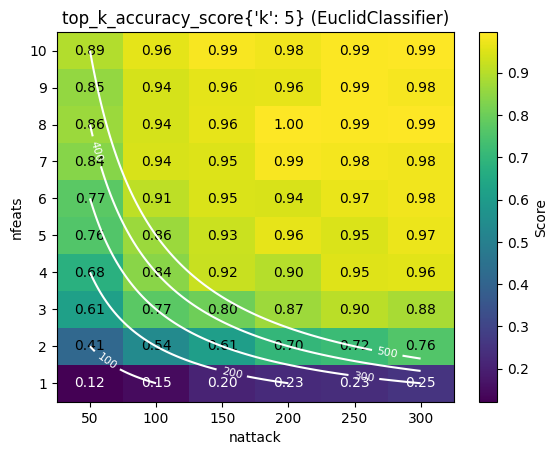

In [77]:
plot_performance(euclid_classifier, top_5_scorer, 500, tre, distributions_mults)

## Simulate distinguishing using a Bayes classifier

We need to first select some features (divisors) from the set of all divisors that we will query
the target with. This set should be the smallest (to not do a lot of queries) yet allow us to distinguish as
much as possible.

Then, we can build a true Bayes classifier. Since our features are conditionally independent (when conditioned on the class label) in our case naive Bayes == non-naive Bayes. We examine four feature selection algorithms:
 - Feature selection by pre-selection using tree-building and final selection by random subsets + classification error.
 - Feature selection via greedy classification error.
 - Feature selection via mRMR (maximal relevance, minimal redundancy) using mutual information.
 - Feature selection via JMI (Joint Mutual Information).

### Feature selection using trees + classification error

We can reuse the clustering + tree building approach above and just take the inputs that the greedy tree building choses as the features. However, we can also use more conventional feature selection approaches.

In [60]:
feats_in_tree = Counter()
for node in PreOrderIter(tree.root):
    if node.is_leaf:
        continue
    feats_in_tree[node.dmap_input] += 1
feats_in_tree = set(feats_in_tree.keys())

In [61]:
simulations = 500
retries = 500
nattack = range(50, 350, 50)
nfeats = range(1, 11)
num_workers = 30

bayes_classifier = BayesClassifier()
tree_random_subsets = RandomFeatures(sorted(feats_in_tree), distributions_mults, num_workers,
                                     simulations, bayes_classifier, top_5_scorer, retries)

bay = feature_search(nfeats, nattack, tree_random_subsets, restarts=True)

nattack:   0%|          | 0/6 [00:00<?, ?it/s]

nfeats:   0%|          | 0/10 [00:00<?, ?it/s]

retries:   0%|          | 0/500 [00:00<?, ?it/s]

50,1: [3072], 0.148


retries:   0%|          | 0/500 [00:00<?, ?it/s]

50,2: [131, 3072], 0.434


retries:   0%|          | 0/500 [00:00<?, ?it/s]

50,3: [296, 12288, 131], 0.646


retries:   0%|          | 0/500 [00:00<?, ?it/s]

50,4: [342, 296, 123, 3072], 0.73


retries:   0%|          | 0/500 [00:00<?, ?it/s]

50,5: [768, 157, 43, 216, 57], 0.814


retries:   0%|          | 0/500 [00:00<?, ?it/s]

50,6: [162, 512, 165, 768, 57, 248], 0.844


retries:   0%|          | 0/500 [00:00<?, ?it/s]

50,7: [21711016731996786641919559689128982722488122124807605757398297001483711807488, 173, 102, 3072, 336, 1024, 103], 0.868


retries:   0%|          | 0/500 [00:00<?, ?it/s]

50,8: [2048, 1176956575385002643219210516851437453019191645837006471168, 85, 33, 12288, 105, 178, 125], 0.892


retries:   0%|          | 0/500 [00:00<?, ?it/s]

50,9: [131, 296, 57, 1024, 102, 99, 196, 17, 192], 0.922


retries:   0%|          | 0/500 [00:00<?, ?it/s]

50,10: [80, 77, 172, 2048, 336, 29, 53, 588478287692501321609605258425718726509595822918503235584, 346, 178], 0.93


nfeats:   0%|          | 0/10 [00:00<?, ?it/s]

retries:   0%|          | 0/500 [00:00<?, ?it/s]

100,1: [1536], 0.178


retries:   0%|          | 0/500 [00:00<?, ?it/s]

100,2: [83, 1536], 0.584


retries:   0%|          | 0/500 [00:00<?, ?it/s]

100,3: [1536, 79, 216], 0.756


retries:   0%|          | 0/500 [00:00<?, ?it/s]

100,4: [342, 248, 57, 3072], 0.862


retries:   0%|          | 0/500 [00:00<?, ?it/s]

100,5: [1536, 95, 325, 1024, 296], 0.924


retries:   0%|          | 0/500 [00:00<?, ?it/s]

100,6: [320, 27, 196, 173, 59, 12288], 0.94


retries:   0%|          | 0/500 [00:00<?, ?it/s]

100,7: [160, 3072, 89, 192, 103, 109, 296], 0.958


retries:   0%|          | 0/500 [00:00<?, ?it/s]

100,8: [65, 75, 105, 55, 1024, 59, 126, 346], 0.972


retries:   0%|          | 0/500 [00:00<?, ?it/s]

100,9: [101, 142, 1024, 80, 2048, 178, 325, 192, 336], 0.984


retries:   0%|          | 0/500 [00:00<?, ?it/s]

100,10: [2048, 173688133855974293135356477513031861779904976998460846059186376011869694459904, 102, 157, 172, 105, 43, 216, 224, 162], 0.984


nfeats:   0%|          | 0/10 [00:00<?, ?it/s]

retries:   0%|          | 0/500 [00:00<?, ?it/s]

150,1: [3072], 0.208


retries:   0%|          | 0/500 [00:00<?, ?it/s]

150,2: [1536, 99], 0.64


retries:   0%|          | 0/500 [00:00<?, ?it/s]

150,3: [276, 59, 768], 0.846


retries:   0%|          | 0/500 [00:00<?, ?it/s]

150,4: [384, 55, 165, 3072], 0.91


retries:   0%|          | 0/500 [00:00<?, ?it/s]

150,5: [1024, 59, 296, 131, 196608], 0.946


retries:   0%|          | 0/500 [00:00<?, ?it/s]

150,6: [165, 256, 105, 131, 3072, 320], 0.97


retries:   0%|          | 0/500 [00:00<?, ?it/s]

150,7: [123, 172, 111, 512, 142, 105, 43], 0.988


retries:   0%|          | 0/500 [00:00<?, ?it/s]

150,8: [2048, 768, 165, 59, 81, 155, 343, 102], 0.99


retries:   0%|          | 0/500 [00:00<?, ?it/s]

150,9: [276, 216, 1536, 109, 768, 21711016731996786641919559689128982722488122124807605757398297001483711807488, 81, 325, 79], 0.996


retries:   0%|          | 0/500 [00:00<?, ?it/s]

150,10: [296, 224, 25, 8388609, 126, 57, 83, 77, 125, 2048], 0.994


nfeats:   0%|          | 0/10 [00:00<?, ?it/s]

retries:   0%|          | 0/500 [00:00<?, ?it/s]

200,1: [3072], 0.242


retries:   0%|          | 0/500 [00:00<?, ?it/s]

200,2: [65, 12288], 0.736


retries:   0%|          | 0/500 [00:00<?, ?it/s]

200,3: [315, 3072, 196], 0.902


retries:   0%|          | 0/500 [00:00<?, ?it/s]

200,4: [325, 43, 2048, 248], 0.948


retries:   0%|          | 0/500 [00:00<?, ?it/s]

200,5: [142, 39, 101, 3072, 512], 0.98


retries:   0%|          | 0/500 [00:00<?, ?it/s]

200,6: [196, 126, 155, 1536, 72, 192], 0.99


retries:   0%|          | 0/500 [00:00<?, ?it/s]

200,7: [53, 224, 1024, 178, 95, 65, 276], 0.992


retries:   0%|          | 0/500 [00:00<?, ?it/s]

200,8: [216, 144, 79, 4194306, 77, 41, 768, 85], 0.998


retries:   0%|          | 0/500 [00:00<?, ?it/s]

200,9: [240, 256, 123, 99, 55, 39, 109, 228, 1024], 1.0


retries:   0%|          | 0/500 [00:00<?, ?it/s]

200,10: [81, 512, 248, 138, 342, 101, 38, 240, 128, 111], 1.0


nfeats:   0%|          | 0/10 [00:00<?, ?it/s]

retries:   0%|          | 0/500 [00:00<?, ?it/s]

250,1: [1536], 0.256


retries:   0%|          | 0/500 [00:00<?, ?it/s]

250,2: [85, 3072], 0.788


retries:   0%|          | 0/500 [00:00<?, ?it/s]

250,3: [123, 1536, 276], 0.924


retries:   0%|          | 0/500 [00:00<?, ?it/s]

250,4: [3072, 138, 172, 75], 0.966


retries:   0%|          | 0/500 [00:00<?, ?it/s]

250,5: [99, 123, 768, 56668397794435742564352, 178], 0.986


retries:   0%|          | 0/500 [00:00<?, ?it/s]

250,6: [325, 1024, 56, 248, 59, 162], 0.992


retries:   0%|          | 0/500 [00:00<?, ?it/s]

250,7: [85, 131, 1536, 296, 123, 53, 329], 1.0


retries:   0%|          | 0/500 [00:00<?, ?it/s]

250,8: [329, 192, 89, 128, 1024, 29, 172, 55], 0.998


retries:   0%|          | 0/500 [00:00<?, ?it/s]

250,9: [3072, 1176956575385002643219210516851437453019191645837006471168, 59, 44, 75, 131, 102, 336, 80], 1.0


retries:   0%|          | 0/500 [00:00<?, ?it/s]

250,10: [85, 33, 109, 72, 53, 2048, 192, 101, 21711016731996786641919559689128982722488122124807605757398297001483711807488, 12288], 1.0


nfeats:   0%|          | 0/10 [00:00<?, ?it/s]

retries:   0%|          | 0/500 [00:00<?, ?it/s]

300,1: [1536], 0.276


retries:   0%|          | 0/500 [00:00<?, ?it/s]

300,2: [109, 768], 0.802


retries:   0%|          | 0/500 [00:00<?, ?it/s]

300,3: [79, 3072, 123], 0.96


retries:   0%|          | 0/500 [00:00<?, ?it/s]

300,4: [1536, 342, 248, 111], 0.984


retries:   0%|          | 0/500 [00:00<?, ?it/s]

300,5: [105, 224, 2048, 157, 65], 0.992


retries:   0%|          | 0/500 [00:00<?, ?it/s]

300,6: [99, 1536, 85, 123, 83, 256], 0.996


retries:   0%|          | 0/500 [00:00<?, ?it/s]

300,7: [144, 216, 125, 65, 25, 1536, 35], 0.998


retries:   0%|          | 0/500 [00:00<?, ?it/s]

300,8: [105, 6, 20, 196, 342, 85, 35, 768], 1.0


retries:   0%|          | 0/500 [00:00<?, ?it/s]

300,9: [276, 65, 512, 228, 192, 16384, 173, 21, 162], 1.0


retries:   0%|          | 0/500 [00:00<?, ?it/s]

300,10: [172, 165, 12, 72, 768, 173688133855974293135356477513031861779904976998460846059186376011869694459904, 123, 84, 173, 1024], 1.0


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

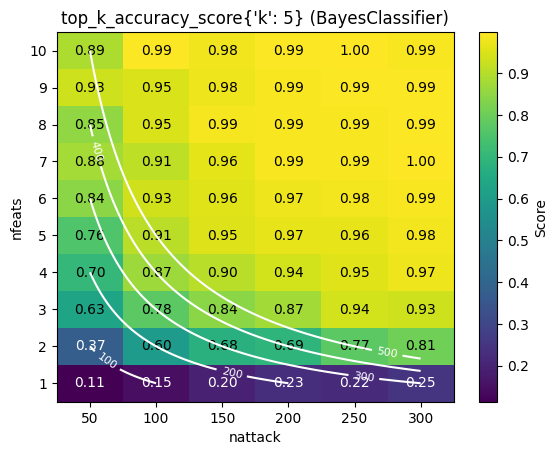

In [78]:
plot_performance(bayes_classifier, top_5_scorer, 500, bay, distributions_mults)

### Feature selection via greedy classification
We can also use the classifier itself for feature selection. We iterate over all the divisors to pick the first feature with the best classifier results in simulation. Then we iteratively add features to it.

In [ ]:
def find_features_greedy(nfeats, nattack, num_workers, simulations, scorer, start_features=None):
    available_feats = selected_divisors
    feats = []
    if start_features is not None:
        if nfeats <= len(start_features):
            raise ValueError("Features already picked.")
        feats.extend(start_features)
        for feat in start_features:
            available_feats.remove(feat)

    with TaskExecutor(max_workers=num_workers) as pool:
        while len(feats) < nfeats:
            for feat in available_feats:
                pool.submit_task(feat,
                                 many_simulations,
                                 nattack, distributions_mults, feats + [feat], scorer, simulations)
            best_feat = None
            best_feat_mean_pos = None
            best_successes = Noned
            for feat, future in tqdm(pool.as_completed(), total=len(available_feats), desc=f"Picking feature {len(feats)}", smoothing=0):
                mean_pos, successes = future.result()
                if best_feat is None or best_feat_mean_pos > mean_pos:
                    best_feat = feat
                    best_feat_mean_pos = mean_pos
                    best_successes = successes
            print(f"Picked {best_feat} with mean pos: {mean_pos:.2f}")
            print(f"top1: {best_successes[1]:.2f}, top2: {best_successes[2]:.2f}, top5: {best_successes[5]:.2f}, top10: {best_successes[10]:.2f}")
            feats.append(best_feat)
            available_feats.remove(best_feat)
    return feats

In [79]:
simulations = 500
nattack = range(50, 350, 50)
nfeats = range(1, 11)
num_workers = 30

bayes_classifier = BayesClassifier()
greedy = GreedyFeatures(sorted(feats_in_tree), distributions_mults, num_workers,
                        simulations, bayes_classifier, top_5_scorer)

gre = feature_search(nfeats, nattack, greedy, restarts=False)

nattack:   0%|          | 0/6 [00:00<?, ?it/s]

nfeats:   0%|          | 0/10 [00:00<?, ?it/s]

50,1: [296], 0.134
50,2: [296, 85], 0.398
50,3: [296, 85, 12288], 0.63
50,4: [296, 85, 12288, 59], 0.762
50,5: [296, 85, 12288, 59, 512], 0.818
50,6: [296, 85, 12288, 59, 512, 248], 0.882
50,7: [296, 85, 12288, 59, 512, 248, 315], 0.9
50,8: [296, 85, 12288, 59, 512, 248, 315, 109], 0.934
50,9: [296, 85, 12288, 59, 512, 248, 315, 109, 33], 0.942
50,10: [296, 85, 12288, 59, 512, 248, 315, 109, 33, 1536], 0.956


nfeats:   0%|          | 0/10 [00:00<?, ?it/s]

100,1: [3072], 0.18
100,2: [3072, 65], 0.626
100,3: [3072, 65, 196], 0.822
100,4: [3072, 65, 196, 240], 0.9
100,5: [3072, 65, 196, 240, 346], 0.936
100,6: [3072, 65, 196, 240, 346, 157], 0.954
100,7: [3072, 65, 196, 240, 346, 157, 336], 0.972
100,8: [3072, 65, 196, 240, 346, 157, 336, 343], 0.982
100,9: [3072, 65, 196, 240, 346, 157, 336, 343, 126], 0.984
100,10: [3072, 65, 196, 240, 346, 157, 336, 343, 126, 172], 0.992


nfeats:   0%|          | 0/10 [00:00<?, ?it/s]

150,1: [1536], 0.198
150,2: [1536, 65], 0.666
150,3: [1536, 65, 296], 0.888
150,4: [1536, 65, 296, 123], 0.958
150,5: [1536, 65, 296, 123, 178], 0.974
150,6: [1536, 65, 296, 123, 178, 315], 0.992
150,7: [1536, 65, 296, 123, 178, 315, 336], 0.994
150,8: [1536, 65, 296, 123, 178, 315, 336, 1024], 0.996
150,9: [1536, 65, 296, 123, 178, 315, 336, 1024, 2048], 0.996
150,10: [1536, 65, 296, 123, 178, 315, 336, 1024, 2048, 248], 0.998


nfeats:   0%|          | 0/10 [00:00<?, ?it/s]

200,1: [1536], 0.218
200,2: [1536, 276], 0.73
200,3: [1536, 276, 109], 0.918
200,4: [1536, 276, 109, 165], 0.978
200,5: [1536, 276, 109, 165, 123], 0.99
200,6: [1536, 276, 109, 165, 123, 212], 0.992
200,7: [1536, 276, 109, 165, 123, 212, 216], 0.998
200,8: [1536, 276, 109, 165, 123, 212, 216, 80], 1.0
200,9: [1536, 276, 109, 165, 123, 212, 216, 80, 224], 1.0
200,10: [1536, 276, 109, 165, 123, 212, 216, 80, 224, 43], 1.0


nfeats:   0%|          | 0/10 [00:00<?, ?it/s]

250,1: [3072], 0.244
250,2: [3072, 95], 0.786
250,3: [3072, 95, 196], 0.944
250,4: [3072, 95, 196, 346], 0.978
250,5: [3072, 95, 196, 346, 99], 0.992
250,6: [3072, 95, 196, 346, 99, 157], 0.998
250,7: [3072, 95, 196, 346, 99, 157, 33], 0.998
250,8: [3072, 95, 196, 346, 99, 157, 33, 53], 1.0
250,9: [3072, 95, 196, 346, 99, 157, 33, 53, 24], 1.0
250,10: [3072, 95, 196, 346, 99, 157, 33, 53, 24, 105], 1.0


nfeats:   0%|          | 0/10 [00:00<?, ?it/s]

300,1: [1536], 0.256
300,2: [1536, 59], 0.822
300,3: [1536, 59, 228], 0.966
300,4: [1536, 59, 228, 224], 0.99
300,5: [1536, 59, 228, 224, 105], 0.996
300,6: [1536, 59, 228, 224, 105, 39], 0.998
300,7: [1536, 59, 228, 224, 105, 39, 72], 1.0
300,8: [1536, 59, 228, 224, 105, 39, 72, 20], 1.0
300,9: [1536, 59, 228, 224, 105, 39, 72, 20, 80], 1.0
300,10: [1536, 59, 228, 224, 105, 39, 72, 20, 80, 79], 1.0


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

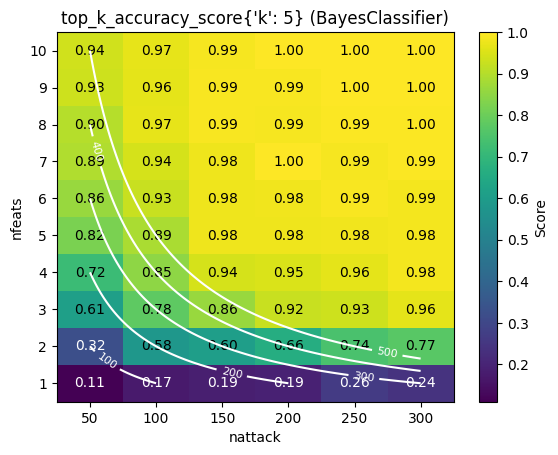

In [80]:
plot_performance(bayes_classifier, top_5_scorer, 500, gre, distributions_mults)

In [83]:
simulations = 500
nattack = range(50, 350, 50)
nfeats = range(1, 11)
num_workers = 30

bayes_classifier = BayesClassifier()
greedy = GreedyFeatures(allfeats, distributions_mults, num_workers,
                        simulations, bayes_classifier, top_5_scorer)

gre = feature_search(nfeats, nattack, greedy, restarts=False)

nattack:   0%|          | 0/6 [00:00<?, ?it/s]

nfeats:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3215 [00:00<?, ?it/s]

50,1: [272], 0.14


  0%|          | 0/3214 [00:00<?, ?it/s]

50,2: [272, 3072], 0.392


  0%|          | 0/3213 [00:00<?, ?it/s]

50,3: [272, 3072, 205], 0.666


  0%|          | 0/3212 [00:00<?, ?it/s]

50,4: [272, 3072, 205, 122], 0.792


  0%|          | 0/3211 [00:00<?, ?it/s]

50,5: [272, 3072, 205, 122, 63], 0.866


  0%|          | 0/3210 [00:00<?, ?it/s]

50,6: [272, 3072, 205, 122, 63, 1020], 0.892


  0%|          | 0/3209 [00:00<?, ?it/s]

50,7: [272, 3072, 205, 122, 63, 1020, 316], 0.916


  0%|          | 0/3208 [00:00<?, ?it/s]

50,8: [272, 3072, 205, 122, 63, 1020, 316, 768], 0.934


  0%|          | 0/3207 [00:00<?, ?it/s]

50,9: [272, 3072, 205, 122, 63, 1020, 316, 768, 248], 0.948


  0%|          | 0/3206 [00:00<?, ?it/s]

50,10: [272, 3072, 205, 122, 63, 1020, 316, 768, 248, 29], 0.966


nfeats:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3215 [00:00<?, ?it/s]

100,1: [328], 0.182


  0%|          | 0/3214 [00:00<?, ?it/s]

100,2: [328, 123], 0.512


  0%|          | 0/3213 [00:00<?, ?it/s]

100,3: [328, 123, 3072], 0.822


  0%|          | 0/3212 [00:00<?, ?it/s]

100,4: [328, 123, 3072, 78], 0.92


  0%|          | 0/3211 [00:00<?, ?it/s]

100,5: [328, 123, 3072, 78, 331], 0.944


  0%|          | 0/3210 [00:00<?, ?it/s]

100,6: [328, 123, 3072, 78, 331, 63], 0.96


  0%|          | 0/3209 [00:00<?, ?it/s]

100,7: [328, 123, 3072, 78, 331, 63, 58], 0.974


  0%|          | 0/3208 [00:00<?, ?it/s]

100,8: [328, 123, 3072, 78, 331, 63, 58, 1025], 0.978


  0%|          | 0/3207 [00:00<?, ?it/s]

100,9: [328, 123, 3072, 78, 331, 63, 58, 1025, 260], 0.984


  0%|          | 0/3206 [00:00<?, ?it/s]

100,10: [328, 123, 3072, 78, 331, 63, 58, 1025, 260, 341], 0.988


nfeats:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3215 [00:00<?, ?it/s]

150,1: [320], 0.206


  0%|          | 0/3214 [00:00<?, ?it/s]

150,2: [320, 91], 0.63


  0%|          | 0/3213 [00:00<?, ?it/s]

150,3: [320, 91, 1536], 0.86


  0%|          | 0/3212 [00:00<?, ?it/s]

150,4: [320, 91, 1536, 244], 0.944


  0%|          | 0/3211 [00:00<?, ?it/s]

150,5: [320, 91, 1536, 244, 59], 0.976


  0%|          | 0/3210 [00:00<?, ?it/s]

150,6: [320, 91, 1536, 244, 59, 299], 0.99


  0%|          | 0/3209 [00:00<?, ?it/s]

150,7: [320, 91, 1536, 244, 59, 299, 274], 0.994


  0%|          | 0/3208 [00:00<?, ?it/s]

150,8: [320, 91, 1536, 244, 59, 299, 274, 290], 0.998


  0%|          | 0/3207 [00:00<?, ?it/s]

150,9: [320, 91, 1536, 244, 59, 299, 274, 290, 135], 1.0


  0%|          | 0/3206 [00:00<?, ?it/s]

150,10: [320, 91, 1536, 244, 59, 299, 274, 290, 135, 87], 1.0


nfeats:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3215 [00:00<?, ?it/s]

200,1: [6144], 0.236


  0%|          | 0/3214 [00:00<?, ?it/s]

200,2: [6144, 165], 0.76


  0%|          | 0/3213 [00:00<?, ?it/s]

200,3: [6144, 165, 368], 0.92


  0%|          | 0/3212 [00:00<?, ?it/s]

200,4: [6144, 165, 368, 59], 0.972


  0%|          | 0/3211 [00:00<?, ?it/s]

200,5: [6144, 165, 368, 59, 150], 0.99


  0%|          | 0/3210 [00:00<?, ?it/s]

200,6: [6144, 165, 368, 59, 150, 2854495385411919762116571938898990272765493250], 0.996


  0%|          | 0/3209 [00:00<?, ?it/s]

200,7: [6144, 165, 368, 59, 150, 2854495385411919762116571938898990272765493250, 17], 0.992


  0%|          | 0/3208 [00:00<?, ?it/s]

200,8: [6144, 165, 368, 59, 150, 2854495385411919762116571938898990272765493250, 17, 1019], 0.996


  0%|          | 0/3207 [00:00<?, ?it/s]

200,9: [6144, 165, 368, 59, 150, 2854495385411919762116571938898990272765493250, 17, 1019, 180], 0.998


  0%|          | 0/3206 [00:00<?, ?it/s]

200,10: [6144, 165, 368, 59, 150, 2854495385411919762116571938898990272765493250, 17, 1019, 180, 343], 1.0


nfeats:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3215 [00:00<?, ?it/s]

250,1: [3072], 0.25


  0%|          | 0/3214 [00:00<?, ?it/s]

250,2: [3072, 65], 0.796


  0%|          | 0/3213 [00:00<?, ?it/s]

250,3: [3072, 65, 248], 0.96


  0%|          | 0/3212 [00:00<?, ?it/s]

250,4: [3072, 65, 248, 139], 0.988


  0%|          | 0/3211 [00:00<?, ?it/s]

250,5: [3072, 65, 248, 139, 262], 0.996


  0%|          | 0/3210 [00:00<?, ?it/s]

250,6: [3072, 65, 248, 139, 262, 16380], 1.0


  0%|          | 0/3209 [00:00<?, ?it/s]

250,7: [3072, 65, 248, 139, 262, 16380, 214], 1.0


  0%|          | 0/3208 [00:00<?, ?it/s]

250,8: [3072, 65, 248, 139, 262, 16380, 214, 6], 1.0


  0%|          | 0/3207 [00:00<?, ?it/s]

250,9: [3072, 65, 248, 139, 262, 16380, 214, 6, 74], 1.0


  0%|          | 0/3206 [00:00<?, ?it/s]

250,10: [3072, 65, 248, 139, 262, 16380, 214, 6, 74, 83], 1.0


nfeats:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3215 [00:00<?, ?it/s]

300,1: [6144], 0.262


  0%|          | 0/3214 [00:00<?, ?it/s]

300,2: [6144, 75], 0.818


  0%|          | 0/3213 [00:00<?, ?it/s]

300,3: [6144, 75, 248], 0.954


  0%|          | 0/3212 [00:00<?, ?it/s]

300,4: [6144, 75, 248, 311], 0.99


  0%|          | 0/3211 [00:00<?, ?it/s]

300,5: [6144, 75, 248, 311, 344], 0.994


  0%|          | 0/3210 [00:00<?, ?it/s]

300,6: [6144, 75, 248, 311, 344, 260], 1.0


  0%|          | 0/3209 [00:00<?, ?it/s]

300,7: [6144, 75, 248, 311, 344, 260, 123], 1.0


  0%|          | 0/3208 [00:00<?, ?it/s]

300,8: [6144, 75, 248, 311, 344, 260, 123, 100], 1.0


  0%|          | 0/3207 [00:00<?, ?it/s]

300,9: [6144, 75, 248, 311, 344, 260, 123, 100, 151], 1.0


  0%|          | 0/3206 [00:00<?, ?it/s]

300,10: [6144, 75, 248, 311, 344, 260, 123, 100, 151, 138], 1.0


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

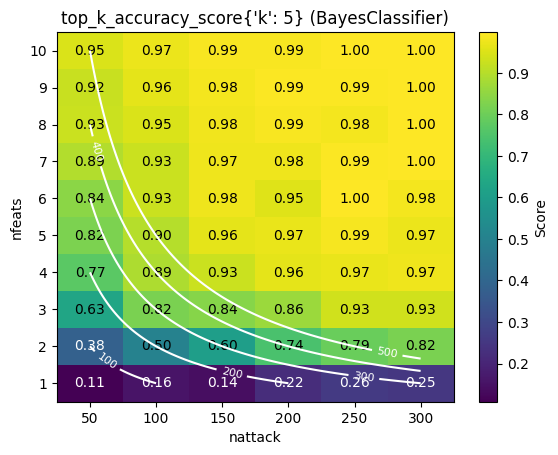

In [89]:
plot_performance(bayes_classifier, top_5_scorer, 500, gre, distributions_mults)

### Feature selection via mRMR using mutual information

In [ ]:
def mutual_information(class_priors, p_ci_list, n):
    """
    Compute mutual information I(X; Y) for a binomial feature with given class parameters.
    
    Args:
        class_priors (np.array): P(Y=c), shape (num_classes,)
        p_ci_list (np.array): Binomial parameters [p_{c,i}] for each class c, shape (num_classes,)
        n (int): Number of trials in binomial distribution
    
    Returns:
        float: Mutual information I(X; Y)
    """
    num_classes = len(class_priors)
    
    # Precompute all PMFs across x and classes
    x_values = np.arange(0, n + 1)[:, None]  # (n+1, 1)
    pmfs = binom.pmf(x_values, n, p_ci_list[None, :])  # Shape: (n+1, num_classes)
    
    # Compute joint probabilities P(Y=c) * P(X=x | Y=c)
    # Multiply class_priors (shape C) with each row of pmfs (each x has shape (C,))
    # class_priors[None, :] becomes (1, C), so broadcasting works.
    joint_probs = pmfs * class_priors[None, :]
    
    # Compute P(X=x) for all x
    px = np.sum(joint_probs, axis=1)

    # Compute H(Y|X):
    h_ygx = 0.0

    for x_idx in range(n + 1):
        current_px = px[x_idx]
        
        if current_px < 1e-9:  # Skip negligible probabilities
            continue
        
        cond_probs = joint_probs[x_idx] / current_px  # P(Y=c | X=x)
        
        # Compute entropy H(Y|X=x) using scipy's entropy function
        h_x = entropy(cond_probs, base=2)
        
        h_ygx += current_px * h_x
    
    # Prior entropy H(Y)
    h_y = entropy(class_priors, base=2)

    return h_y - h_ygx


def mutual_information_between_features(class_priors, p_ci_i, p_ci_j, n):
    """
    Compute mutual information between two features X_i and X_j.
    
    Parameters:
        class_priors (array): Prior probabilities of each class. Shape: (num_classes,)
        p_ci_i (array): Binomial parameters for feature i across classes. Shape: (num_classes,)
        p_ci_j (array): Binomial parameters for feature j across classes. Shape: (num_classes,)
        n (int): Number of trials for the binomial distribution.
    
    Returns:
        float: Mutual information I(X_i; X_j)
    """
    num_classes = len(class_priors)
    x_vals = np.arange(0, n + 1)  # Possible values of features
    
    ### Compute marginal distributions P(Xi=x), P(Xj=y) ###
    # PMF for feature i across all classes
    pmf_i_per_class = binom.pmf(x_vals[:, None], n, p_ci_i[None, :])
    px_i = np.sum(pmf_i_per_class * class_priors[None, :], axis=1)
    entropy_xi = entropy(px_i, base=2) if not np.allclose(px_i, 0.0) else 0.0
    
    # PMF for feature j across all classes
    pmf_j_per_class = binom.pmf(x_vals[:, None], n, p_ci_j[None, :])
    px_j = np.sum(pmf_j_per_class * class_priors[None, :], axis=1)
    entropy_xj = entropy(px_j, base=2) if not np.allclose(px_j, 0.0) else 0.0
    
    ### Compute joint distribution P(Xi=x, Xj=y) ###
    joint_xy = np.zeros((n + 1, n + 1))
    
    for c in range(num_classes):
        pmf_i_c = binom.pmf(x_vals, n, p_ci_i[c])
        pmf_j_c = binom.pmf(x_vals, n, p_ci_j[c])
        
        # Outer product gives joint PMF for class c
        outer = np.outer(pmf_i_c, pmf_j_c)
        joint_xy += class_priors[c] * outer
    
    # Compute entropy of the joint distribution
    epsilon = 1e-10  # To avoid log(0) issues
    non_zero = (joint_xy > epsilon)
    entropy_joint = -np.sum(joint_xy[non_zero] * np.log2(joint_xy[non_zero]))
    
    ### Mutual Information ###
    mi = entropy_xi + entropy_xj - entropy_joint
    
    return mi


def conditional_mutual_info(class_priors, XJ_params, XK_params, n):
    """
    Compute I(XK; Y | XJ) using vectorization with broadcasting.
    
    Args:
        XJ_params (array): p_{c,J} for all classes c.
        XK_params (array): p_{c,K} for all classes c.
        class_priors (array): P(Y=c) for all classes c.
        n (int): Number of trials in the binomial distribution.

    Returns:
        float: Conditional mutual information I(XK; Y | XJ).
    """
    K = len(class_priors)
    x_values = np.arange(n + 1)

    # Precompute PMFs for each class
    P_XJ_giv_Y = binom.pmf(x_values[:, None], n, XJ_params)  
    P_XK_giv_Y = binom.pmf(x_values[:, None], n, XK_params)  

    P_XJ_T = P_XJ_giv_Y.T  # Shape: (K, n+1)
    P_XK_T = P_XK_giv_Y.T

    ######################################################################
    ### Compute H(Y | XJ) ###############################################
    ######################################################################

    # Calculate P(XJ=xj) for all xj
    P_XJ_total = np.dot(class_priors, P_XJ_T)

    # Numerators of posterior probabilities P(Y=c | XJ=xj)
    numerators_YgXJ = class_priors[:, None] * P_XJ_T  

    valid_mask = P_XJ_total > 1e-9
    posterior_YgXJ = np.zeros_like(numerators_YgXJ, dtype=float)
    posterior_YgXJ[:, valid_mask] = (
        numerators_YgXJ[:, valid_mask] / 
        P_XJ_total[valid_mask]
    )

    log_p = np.log2(posterior_YgXJ + 1e-9)  
    entropy_terms_HYgXJ = -np.sum(
        posterior_YgXJ * log_p, 
        axis=0,
        where=(posterior_YgXJ > 1e-9)
    )
    
    H_Y_given_XJ = np.dot(P_XJ_total, entropy_terms_HYgXJ)

    ######################################################################
    ### Compute H(Y | XJ, XK) ###########################################
    ######################################################################

    # Broadcast to compute joint PMF P(XJ=xj, XK=xk | Y=c)
    P_XJ_giv_Y_T = P_XJ_T[..., None]  # Shape: (K, n+1, 1)
    P_XK_giv_Y_T = P_XK_T[:, None, :]  # Shape: (K, 1, n+1)

    joint_pmf_conditional = (
        P_XJ_giv_Y_T * 
        P_XK_giv_Y_T
    )  # Shape: (K, n+1, n+1)

    numerators = class_priors[:, None, None] * joint_pmf_conditional  

    denominators = np.sum(numerators, axis=0)  # Shape: (n+1, n+1)

    valid_mask_3d = (denominators > 1e-9)[None, ...]  # Expand for class dimension

    # Compute posterior probabilities using broadcasting and where
    posterior_YgXJXK = numerators / denominators[None, ...]
    posterior_YgXJXK = np.where(valid_mask_3d, posterior_YgXJXK, 0.0)

    log_p_joint = np.log2(posterior_YgXJXK + 1e-9)  
    entropy_terms_HYgXJXK = -np.sum(
        posterior_YgXJXK * log_p_joint,
        axis=0,  # Sum over classes (axis 0 is K)
        where=(posterior_YgXJXK > 1e-9),
    )

    H_Y_given_XJXK = np.sum(denominators * entropy_terms_HYgXJXK)

    ######################################################################
    ### Compute CMI #####################################################
    ######################################################################

    cmi = H_Y_given_XJ - H_Y_given_XJXK

    return max(cmi, 0.0)  

#### Relevance and redundancy
First, lets pre-compute the relevance and redundancy metrics for mRMR (also used in JMI). We assume a uniform class prior.

In [ ]:
priors = np.full(nmults, 1/nmults, dtype=np.float64)
probs = np.zeros((nallfeats, nmults), dtype=np.float64)
for i, divisor in enumerate(allfeats):
    for j, (mult, probmap) in enumerate(distributions_mults.items()):
        probs[i, j] = probmap[divisor]

nattack = 100
mis = []
relevance = np.zeros(nallfeats, dtype=np.float64)
for i, divisor in enumerate(allfeats):
    mi = mutual_information(priors, probs[i, ], nattack)
    relevance[i] = mi
    mis.append((mi, divisor))
mis.sort(key=lambda item: item[0], reverse=True)

print("Top 10 feats")
for mi, divisor in mis[:10]:
    print(f"{divisor} {mi:.3f}")

In [ ]:
num_workers = 30

redundancy = np.zeros((nallfeats, nallfeats), dtype=np.float64)
with TaskExecutor(max_workers=num_workers) as pool:
    for i in trange(nallfeats):
        for j in range(nallfeats):
            if i < j:
                continue
            pool.submit_task((i, j),
                             mutual_information_between_features,
                             priors, probs[i, ], probs[j, ], nattack)
        for (i, j), future in pool.as_completed():
            mi = future.result()
            redundancy[i][j] = mi
            redundancy[j][i] = mi


Store the relevance and redundancy arrays.

In [ ]:
with open("relevance.pickle", "wb") as f:
    pickle.dump(relevance, f)
with open("redundancy.pickle", "wb") as f:
    pickle.dump(redundancy, f)

In [ ]:
def mrmr_selection(relevance, redundancy, nfeats):
    """
    Select top features using mRMR.
    
    Returns:
        indices of selected features.
    """
    selected_indices = []
    remaining_indices = list(range(nallfeats))
    
    # Initialize by selecting the most relevant feature
    first_feature_idx = np.argmax(relevance)
    selected_indices.append(first_feature_idx)
    remaining_indices.remove(first_feature_idx)
    
    while len(selected_indices) < nfeats:
        candidates_scores = []
        
        for candidate in remaining_indices:
            # Compute mRMR score: relevance - average redundancy with selected features
            current_relevance = relevance[candidate]
            
            avg_red = 0.0
            if len(selected_indices) > 0:
                sum_red = np.sum(redundancy[candidate][selected_indices])
                avg_red = sum_red / len(selected_indices)
            
            score = current_relevance - avg_red
            candidates_scores.append(score)
        
        # Select the candidate with highest score
        best_candidate_idx = remaining_indices[np.argmax(candidates_scores)]
        selected_indices.append(best_candidate_idx)
        remaining_indices.remove(best_candidate_idx)
    
    return selected_indices

In [ ]:
selected_mrmr = [allfeats[i] for i in mrmr_selection(relevance, redundancy, nfeats=5)]

### Feature selection via JMI

In [ ]:
def jmi_selection(features_params_list, class_priors, n_trials, relevance, nfeats):
    """
    Select top features using JMI.
    
    Returns:
        indices of selected features.
    """
    selected_indices = []
    remaining_indices = list(range(nallfeats))
    
    # Initialize by selecting the most relevant feature
    first_feature_idx = np.argmax(relevance)
    selected_indices.append(first_feature_idx)
    remaining_indices.remove(first_feature_idx)
    
    while len(selected_indices) < nfeats:
        candidates_scores = []
        
        for candidate in tqdm(remaining_indices):
            # Compute mRMR score: relevance - average redundancy with selected features
            current_relevance = relevance[candidate]
            
            sum_cmi = 0.0
            for selected in selected_indices:
                XJ_params = features_params_list[selected]
                XK_params = features_params_list[candidate]
                
                cmi_val = conditional_mutual_info(
                    class_priors=class_priors,
                    XJ_params=XJ_params,
                    XK_params=XK_params,
                    n=n_trials
                )
                sum_cmi += cmi_val
            avg_cmi = sum_cmi / len(selected_indices)
            score = current_relevance + avg_cmi
            candidates_scores.append(score)
        
        # Select the candidate with highest score
        best_candidate_idx = remaining_indices[np.argmax(candidates_scores)]
        selected_indices.append(best_candidate_idx)
        remaining_indices.remove(best_candidate_idx)
    
    return selected_indices

In [ ]:
selected_jmi = [allfeats[i] for i in jmi_selection(probs, priors, nattack, relevance, nfeats=5)]